# Проверка работы скрипта на датасете с [Kaggle](https://www.kaggle.com/datasets/sergylog/ab-test-data?resource=download)


Параметры: CSV=datasets/AB_Test_results.csv, MDE=0.07, alpha=0.05, power=0.8
Загружено строк: 10000, колонки: ['USER_ID', 'VARIANT_NAME', 'REVENUE']

Тип метрики 'REVENUE': continuous
Z-тест пропущен (метрика не бинарная).

ПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ:
   Control: ✗ Ненормальное (skew=56.63, kurt=3620.73)
   Test:    ✗ Ненормальное (skew=36.58, kurt=1534.61)
   → Используется: Bootstrap (распределения ненормальные)


A/B ТЕСТ: АНАЛИЗ РЕЗУЛЬТАТОВ

БАЗОВЫЕ МЕТРИКИ ПО ГРУППАМ:
          Mean    Std         N
variant 0.0701 1.3148 5016.0000
control 0.1290 3.0075 4984.0000

Z-ТЕСТ (для пропорций):
  Метрика не подходит для Z-теста (требуется 0/1)

СТАТИСТИЧЕСКИЙ ТЕСТ (для средних):
   Метод: Bootstrap
   p-value: 0.46630 (Не значимый, alpha=0.05)
   Effect size: -0.0254 (Test: 0.0701, Control: 0.129)
   95% CI: [-0.1616, 0.0171]

POWER ANALYSIS (мощность 80.0%, alpha=0.05):
  Рекомендуемый размер выборки: 3205 на группу (для MDE=0.07)
   Текущая выборка (5016.0 в тест-группе) достат

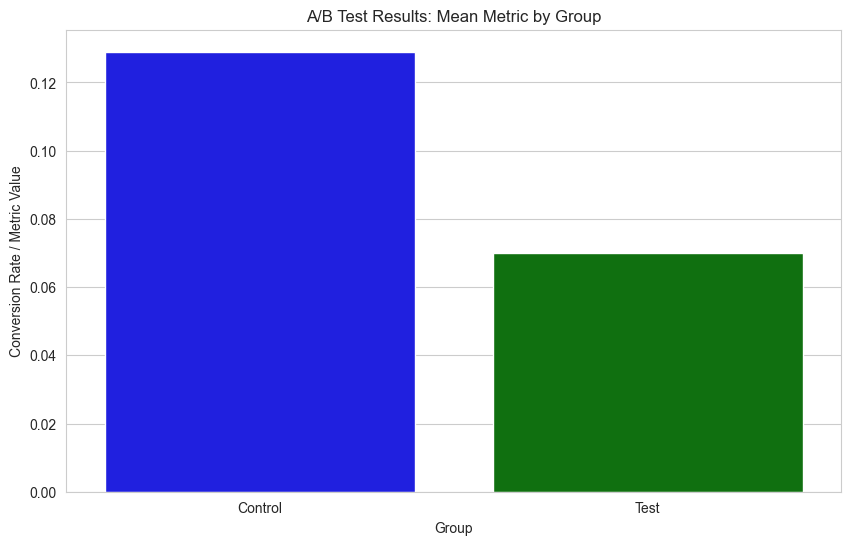

In [36]:
import pandas as pd
import numpy as np
import os
from statsmodels.stats.proportion import proportions_ztest  # Z-test для пропорций
from statsmodels.stats.weightstats import ttest_ind  # T-test для метрик
from statsmodels.stats.power import TTestIndPower  # Power analysis
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict
from scipy import stats


# Ввод параметров A/B-теста
csv_filename = "datasets/AB_Test_results.csv"
mde = 0.07
alpha = 0.05
power = 0.8
print(f"Параметры: CSV={csv_filename}, MDE={mde}, alpha={alpha}, power={power}")

# Названия колонок в CSV
control_col = "VARIANT_NAME"
metric_col = "REVENUE"

# Названия контрольных и тестовых групп в control_col
control_group_name = "control"
test_group_name = "variant"

# Обработка выбросов/аномалий
handle_outliers = False
outlier_method = "IQR"  # "IQR", "zscore", "percentile"
outlier_threshold = 1.5
outlier_action = "remove"  # "remove", "winsorize"
percentile_lower = 1
percentile_upper = 99


def handle_outliers_func(
    df, metric_col, method="IQR", threshold=1.5, action="remove", p_lower=1, p_upper=99
):
    """
    Обнаруживает и обрабатывает выбросы в данных.
    """
    if metric_col not in df.columns:
        return df, 0

    # Проверка: если метрика бинарная, пропускаем обработку
    unique_values = df[metric_col].dropna().unique()
    if len(unique_values) <= 2 and set(unique_values).issubset({0, 1, 0.0, 1.0}):
        print(f"Метрика '{metric_col}' бинарная (0/1) — обработка выбросов пропущена.")
        return df, 0

    original_len = len(df)
    data = df[metric_col].copy()

    # Детекция выбросов
    if method == "IQR":
        Q1 = data.quantile(0.25)
        Q3 = data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
    elif method == "zscore":
        mean = data.mean()
        std = data.std()
        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std
    elif method == "percentile":
        lower_bound = data.quantile(p_lower / 100)
        upper_bound = data.quantile(p_upper / 100)
    else:
        return df, 0

    # Применение действия
    if action == "remove":
        df_clean = df[(data >= lower_bound) & (data <= upper_bound)].copy()
        outliers_count = original_len - len(df_clean)
        return df_clean, outliers_count
    elif action == "winsorize":
        df_clean = df.copy()
        df_clean.loc[data < lower_bound, metric_col] = lower_bound
        df_clean.loc[data > upper_bound, metric_col] = upper_bound
        outliers_count = ((data < lower_bound) | (data > upper_bound)).sum()
        return df_clean, outliers_count

    return df, 0


def check_normality(data, alpha=0.05):
    """Проверка нормальности распределения"""
    from scipy import stats

    sample = data if len(data) <= 5000 else np.random.choice(data, 5000, replace=False)
    skewness = stats.skew(sample)
    kurtosis = stats.kurtosis(sample)
    is_normal = abs(skewness) < 2 and abs(kurtosis) < 7
    return is_normal, skewness, kurtosis


def bootstrap_test(control_data, test_data, alpha=0.05, n_resamples=10000):
    """Bootstrap тест для ненормальных распределений"""
    np.random.seed(42)
    observed_diff = np.mean(test_data) - np.mean(control_data)

    bootstrap_diffs = []
    for _ in range(n_resamples):
        control_sample = np.random.choice(
            control_data, size=len(control_data), replace=True
        )
        test_sample = np.random.choice(test_data, size=len(test_data), replace=True)
        bootstrap_diffs.append(np.mean(test_sample) - np.mean(control_sample))

    bootstrap_diffs = np.array(bootstrap_diffs)
    ci_lower = np.percentile(bootstrap_diffs, (alpha / 2) * 100)
    ci_upper = np.percentile(bootstrap_diffs, (1 - alpha / 2) * 100)
    p_value = np.sum(np.abs(bootstrap_diffs) >= np.abs(observed_diff)) / n_resamples

    combined = np.concatenate([control_data, test_data])
    effect_size = observed_diff / np.std(combined) if len(combined) > 0 else 0

    return {
        "test_type": "Bootstrap",
        "statistic": observed_diff,
        "p_value": p_value,
        "significant": not (ci_lower <= 0 <= ci_upper),
        "alpha": alpha,
        "control_mean": np.mean(control_data),
        "test_mean": np.mean(test_data),
        "effect_size": effect_size,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper,
    }


class ABTestAnalyzer:
    """
    Класс для A/B-тестирования на statsmodels.
    Поддержка z/t-тестов, метрик, power analysis.
    """

    def __init__(
        self,
        data: pd.DataFrame,
        control_col: str = control_col,
        metric_col: str = metric_col,
        control_name: str = control_group_name,
        test_name: str = test_group_name,
    ):
        # Проверки данных
        if data.empty:
            raise ValueError("Данные пусты! Проверьте CSV-файл.")
        if control_col not in data.columns or metric_col not in data.columns:
            raise ValueError(
                f"Колонки '{control_col}' или '{metric_col}' отсутствуют в данных."
            )

        self.data = data.dropna(
            subset=[control_col, metric_col]
        )  # Удаляем NaN в ключевых колонках
        if self.data.empty:
            raise ValueError("Все данные NaN после очистки.")
        self.control_col = control_col
        self.metric_col = metric_col
        self.control_name = control_group_name
        self.test_name = test_group_name

    def detect_metric_type(self) -> str:
        unique_vals = self.data[self.metric_col].dropna().unique()
        if len(unique_vals) <= 2 and set(unique_vals).issubset({0, 1, 0.0, 1.0}):
            return "binary"
        return "continuous"

    def calculate_metrics(self) -> pd.DataFrame:
        """Расчёт базовых метрик по группам в таблице (с фиксом NaN/пустых групп)."""
        metrics_dict = {}
        groups = self.data[self.control_col].unique()

        if len(groups) < 2:
            print("Предупреждение: Менее 2 групп — тест невозможен.")
            return pd.DataFrame()  # Пустая таблица

        for group in groups:
            group_data = self.data[self.data[self.control_col] == group][
                self.metric_col
            ]
            if len(group_data) == 0:
                continue
            mean_val = group_data.mean()
            std_val = group_data.std()
            metrics_dict[group] = {
                "Mean": 0 if pd.isna(mean_val) else round(mean_val, 4),
                "Std": 0 if pd.isna(std_val) else round(std_val, 4),
                "N": len(group_data),
            }

        if not metrics_dict:
            print("Нет валидных данных для метрик.")
            return pd.DataFrame()

        df_metrics = pd.DataFrame(metrics_dict).T
        return df_metrics

    def proportion_ztest(self, alpha: float = 0.05) -> Dict:
        """Z-тест для пропорций (conversion rate)."""
        control_data = self.data[self.data[self.control_col] == control_group_name][
            self.metric_col
        ]
        test_data = self.data[self.data[self.control_col] == test_group_name][
            self.metric_col
        ]

        if len(control_data) == 0 or len(test_data) == 0:
            return {
                "error": f"Недостаточно данных: Control={len(control_data)}, Test={len(test_data)}"
            }

        count = np.array([control_data.sum(), test_data.sum()])
        nobs = np.array([len(control_data), len(test_data)])

        try:
            stat, p_value = proportions_ztest(count, nobs)
            return {
                "statistic": round(stat, 4),
                "p_value": round(p_value, 5),
                "significant": p_value < alpha,
                "alpha": alpha,
                "control_rate": round(control_data.mean(), 4),
                "test_rate": round(test_data.mean(), 4),
                "uplift": (
                    round(
                        (test_data.mean() - control_data.mean())
                        / control_data.mean()
                        * 100,
                        2,
                    )
                    if control_data.mean() > 0
                    else 0
                ),
            }
        except Exception as e:
            return {"error": f"Ошибка в Z-test: {str(e)}"}

    def t_test(self, alpha: float = 0.05) -> Dict:
        """T-тест с автоматическим выбором между T-test и Bootstrap."""
        control_data = self.data[self.data[self.control_col] == control_group_name][
            self.metric_col
        ]
        test_data = self.data[self.data[self.control_col] == test_group_name][
            self.metric_col
        ]

        if len(control_data) == 0 or len(test_data) == 0:
            return {
                "error": f"Недостаточно данных: Control={len(control_data)}, Test={len(test_data)}"
            }

        control_arr = control_data.values[~np.isnan(control_data.values)]
        test_arr = test_data.values[~np.isnan(test_data.values)]

        if len(control_arr) == 0 or len(test_arr) == 0:
            return {"error": "Все значения NaN после очистки"}

        # Проверка нормальности
        is_normal_control, skew_c, kurt_c = check_normality(control_arr, alpha)
        is_normal_test, skew_t, kurt_t = check_normality(test_arr, alpha)

        print(f"\nПРОВЕРКА НОРМАЛЬНОСТИ РАСПРЕДЕЛЕНИЯ:")
        print(
            f"   Control: {'✓ Нормальное' if is_normal_control else '✗ Ненормальное'} (skew={skew_c:.2f}, kurt={kurt_c:.2f})"
        )
        print(
            f"   Test:    {'✓ Нормальное' if is_normal_test else '✗ Ненормальное'} (skew={skew_t:.2f}, kurt={kurt_t:.2f})"
        )

        if is_normal_control and is_normal_test:
            print(f"   → Используется: T-test (распределения нормальные)\n")
            try:
                res = ttest_ind(test_arr, control_arr, alternative="two-sided")
                stat, p_value, _ = res
                combined = np.concatenate([control_arr, test_arr])
                effect = (
                    (test_arr.mean() - control_arr.mean()) / np.std(combined)
                    if len(combined) > 0
                    else 0
                )

                return {
                    "test_type": "T-test",
                    "statistic": round(stat, 4),
                    "p_value": round(p_value, 5),
                    "significant": p_value < alpha,
                    "alpha": alpha,
                    "control_mean": round(control_arr.mean(), 4),
                    "test_mean": round(test_arr.mean(), 4),
                    "effect_size": round(effect, 4),
                }
            except Exception as e:
                return {"error": f"Ошибка в T-test: {str(e)}"}
        else:
            print(f"   → Используется: Bootstrap (распределения ненормальные)\n")
            try:
                result = bootstrap_test(
                    control_arr, test_arr, alpha=alpha, n_resamples=10000
                )
                return {
                    "test_type": result["test_type"],
                    "statistic": round(result["statistic"], 4),
                    "p_value": round(result["p_value"], 5),
                    "significant": result["significant"],
                    "alpha": alpha,
                    "control_mean": round(result["control_mean"], 4),
                    "test_mean": round(result["test_mean"], 4),
                    "effect_size": round(result["effect_size"], 4),
                    "ci_lower": round(result["ci_lower"], 4),
                    "ci_upper": round(result["ci_upper"], 4),
                }
            except Exception as e:
                return {"error": f"Ошибка в Bootstrap: {str(e)}"}

    def power_analysis(self, effect_size: float, alpha: float, power: float) -> int:
        """Расчёт sample size для теста на основе пользовательских параметров."""
        analysis = TTestIndPower()
        sample_size = analysis.solve_power(
            effect_size=effect_size, alpha=alpha, power=power, ratio=1
        )
        return int(np.ceil(sample_size))

    def plot_results(self, results: Dict):
        """Визуализация результатов (только show, без сохранения)."""
        if "error" in results:
            print(f"Нет данных для графика: {results['error']}")
            return

        plt.figure(figsize=(10, 6))
        groups = ["Control", "Test"]
        means = (
            [results["control_rate"], results["test_rate"]]
            if "control_rate" in results
            else [results["control_mean"], results["test_mean"]]
        )

        sns.barplot(
            x=groups, y=means, hue=groups, palette=["blue", "green"], legend=False
        )
        plt.title("A/B Test Results: Mean Metric by Group")
        plt.ylabel("Conversion Rate / Metric Value")
        plt.xlabel("Group")
        plt.show()

    def print_results(
        self,
        z_results: Dict,
        t_results: Dict,
        metrics: pd.DataFrame,
        sample_size: int,
        alpha: float,
    ):
        """Вывод результатов."""
        # Заголовок
        print("\n" + "=" * 50)
        print("A/B ТЕСТ: АНАЛИЗ РЕЗУЛЬТАТОВ")
        print("=" * 50)

        # Метрики
        print("\nБАЗОВЫЕ МЕТРИКИ ПО ГРУППАМ:")
        if metrics.empty:
            print("Нет данных для метрик. Проверьте CSV-файл.")
        else:
            print(metrics.to_string(float_format="%.4f"))

        # Z-тест
        print("\nZ-ТЕСТ (для пропорций):")
        if "error" in z_results:
            print(f"  {z_results['error']}")
        else:
            sig_text = " (H0 отвергнута)" if z_results["significant"] else ""
            print(f"  p-value: {z_results['p_value']:.5f}{sig_text}, alpha={alpha}")
            print(
                f"  Uplift: +{z_results['uplift']}% (Test: {z_results['test_rate']}, Control: {z_results['control_rate']})"
            )
            if z_results["significant"]:
                print("  Вывод: Разница статистически значима!")
            else:
                print("\nZ-ТЕСТ: Пропущен (метрика не бинарная)")

        # T-тест / Bootstrap
        print("\nСТАТИСТИЧЕСКИЙ ТЕСТ (для средних):")
        if "error" in t_results:
            print(f"   {t_results['error']}")
        else:
            test_name = t_results.get("test_type", "T-test")
            sig_text = (
                "Значимый (отклоняем H0)" if t_results["significant"] else "Не значимый"
            )

            print(f"   Метод: {test_name}")
            print(f"   p-value: {t_results['p_value']:.5f} ({sig_text}, alpha={alpha})")
            print(
                f"   Effect size: {t_results['effect_size']} (Test: {t_results['test_mean']}, Control: {t_results['control_mean']})"
            )

            if test_name == "Bootstrap":
                print(
                    f"   95% CI: [{t_results.get('ci_lower', 'N/A')}, {t_results.get('ci_upper', 'N/A')}]"
                )

            if t_results["significant"]:
                print("   Рекомендация: Разница значима — тест лучше.")

        # POWER ANALYSIS
        print(f"\nPOWER ANALYSIS (мощность {power*100}%, alpha={alpha}):")
        print(
            f"  Рекомендуемый размер выборки: {sample_size} на группу (для MDE={mde})"
        )

        if not metrics.empty:
            test_n = (
                metrics.loc[self.test_name, "N"]
                if self.test_name in metrics.index and "N" in metrics.columns
                else 0
            )
            if test_n < sample_size:
                print(
                    f"   Текущая выборка ({test_n} в тест-группе) мала для MDE={mde} — рискуем пропустить эффект. Соберите больше данных."
                )
            else:
                print(
                    f"   Текущая выборка ({test_n} в тест-группе) достаточна для MDE={mde}."
                )


# Пример использования
if __name__ == "__main__":

    # Проверка данных
    if not os.path.exists(csv_filename):
        print(f"CSV файл не найден: {csv_filename}")
        exit(1)

    df_check = pd.read_csv(csv_filename)
    groups = df_check[control_col].unique() if control_col in df_check.columns else []
    if control_group_name not in groups or test_group_name not in groups:
        print(
            f"В данных отсутствуют группы '{control_group_name}' и/или '{test_group_name}'. Найдены: {list(groups)}"
        )
        exit(1)

    # Загрузка
    df = pd.read_csv(csv_filename)
    print(f"Загружено строк: {len(df)}, колонки: {df.columns.tolist()}")

    # Обработка выбросов
    if handle_outliers:
        df_before = len(df)
        df, outliers = handle_outliers_func(
            df,
            metric_col=metric_col,
            method=outlier_method,
            threshold=outlier_threshold,
            action=outlier_action,
            p_lower=percentile_lower,
            p_upper=percentile_upper,
        )

        if handle_outliers:
            if outliers > 0:  # Только если были выбросы
                print(
                    f"\nОбработка выбросов ({outlier_method}, action={outlier_action}):"
                )
                print(f"  Обнаружено выбросов: {outliers}")
                print(
                    f"  Строк после обработки: {len(df)} (удалено: {df_before - len(df)})"
                )
            else:
                print(
                    f"\nОбработка выбросов: выбросов не обнаружено (метод: {outlier_method})."
                )

    # Инициализация
    try:
        analyzer = ABTestAnalyzer(
            df,
            control_col=control_col,
            metric_col=metric_col,
            control_name=control_group_name,
            test_name=test_group_name,
        )
    except ValueError as e:
        print(f"Ошибка данных: {e}")
        exit(1)

    # Определяем тип метрики ДО вызова тестов
    metric_type = analyzer.detect_metric_type()
    print(f"\nТип метрики '{metric_col}': {metric_type}")

    # Вычисляем метрики
    metrics = analyzer.calculate_metrics()

    # Выполняем тесты в зависимости от типа метрики
    if metric_type == "binary":
        z_results = analyzer.proportion_ztest(alpha=alpha)
    else:
        print("Z-тест пропущен (метрика не бинарная).")
        z_results = {"error": "Метрика не подходит для Z-теста (требуется 0/1)"}

    # T-тест выполняем всегда
    t_results = analyzer.t_test(alpha=alpha)
    sample_size = analyzer.power_analysis(effect_size=mde, alpha=alpha, power=power)

    # Вывод результатов
    analyzer.print_results(z_results, t_results, metrics, sample_size, alpha)

    # Визуализация (используем подходящий результат)
    if metric_type == "binary" and "error" not in z_results:
        analyzer.plot_results(z_results)
    elif "error" not in t_results:
        analyzer.plot_results(t_results)
    else:
        print("\nВизуализация невозможна: нет корректных результатов теста.")
